In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import cigsegy
from tqdm import tqdm
from sklearn.cluster import KMeans,MiniBatchKMeans
import os
import sys
sys.path.append('../')
from utils import *

In [2]:
rootpath = '../../../data/boxing/'
n3,n2,n1 = 1121,881,1251
sx = np.fromfile(rootpath+'lith_int.dat',dtype=np.float32).reshape(n3,n2,n1)
lithHor = np.load(rootpath+'lithHor.npz')
hor1 = (np.fromfile(rootpath+'New_T6x.dat',dtype=np.float32).reshape(n3,n2)-1000)/2
hor1[hor1<0]=0
hor2 = (np.fromfile(rootpath+'New_T6xb1.dat',dtype=np.float32).reshape(n3,n2)-1000)/2
hor2[hor2<0]=0
hor3 = (np.fromfile(rootpath+'T7_new_5.dat',dtype=np.float32).reshape(n3,n2)-1000)/2
hor3[hor3<0]=0

In [4]:
# dir = os.listdir(rootpath + 'transfer')
# for i in dir:
#     if 'sgy' in i:
#         print(i)
#         d = np.zeros((n3,n2,n1))
#         d[:,:,14:-14] = cigsegy.collect(rootpath + 'transfer/' + i).reshape(n3,n2,1223)
#         d.astype(np.float32).tofile(i.split('.')[0]+'.dat')
        

In [3]:
# lith_int = np.fromfile(rootpath+'qx.dat',dtype=np.float32).reshape(n3,n2)
# d = np.flip(lith_int,axis=1)
# d = d.reshape(n3,n2,1).repeat(n1,axis=2)
# d.astype(np.float32).tofile(rootpath+'lith_int.dat')

In [3]:
def show_hord(sx,hor,s):
    d = np.zeros((hor.shape[0], hor.shape[1]))
    for i in range(sx.shape[0]):
        for j in range(sx.shape[1]):
            dep = round(hor[i,j]) +s
            if dep>0:
                d[i,j] = sx[i,j,dep]
    return d

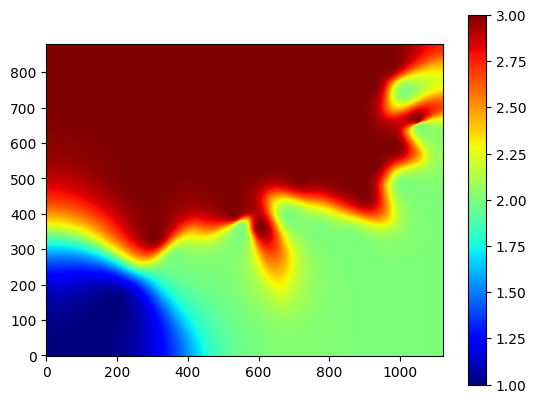

In [4]:
plt.imshow(abs(show_hord(sx,hor2,20)).T,origin='lower',cmap='jet')
plt.colorbar()

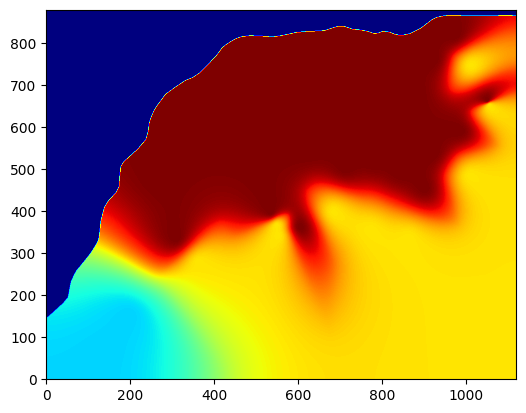

In [5]:
plt.imshow(abs(show_hord(sx,hor2,0)).T,origin='lower',cmap='jet')

In [6]:
# plt.figure(figsize=(20,70))
# for i in tqdm(range(-5,50)):
#     plt.subplot(15,4,i+6)
#     plt.imshow(abs(show_hord(sx,hor2,i)).T,origin='lower',cmap='jet')
#     plt.title(str(i))

In [7]:
# d1 = np.zeros((n3,n2,n1))
# d1 = np.fromfile(rootpath+'transfer/'+'instan_phase.dat',dtype=np.float32).reshape(n3,n2,n1)
# plt.imshow(d1[100].T,cmap='seismic')

In [8]:
# d1 = np.zeros((n3,n2,n1))
# d1[:,:,14:-14] = cigsegy.collect(rootpath+'transfer/'+'instan_phase.sgy').reshape(n3,n2,1223)
# plt.imshow(d1[100].T,cmap='seismic')

In [9]:
# d2 = np.zeros((n3,n2,n1))
# d2[:,:,14:-14] = cigsegy.collect(rootpath+'transfer/'+'instan_frequency.sgy').reshape(n3,n2,1223)
# plt.imshow(d2[100].T,cmap='seismic')

100%|██████████| 42/42 [07:56<00:00, 11.34s/it]


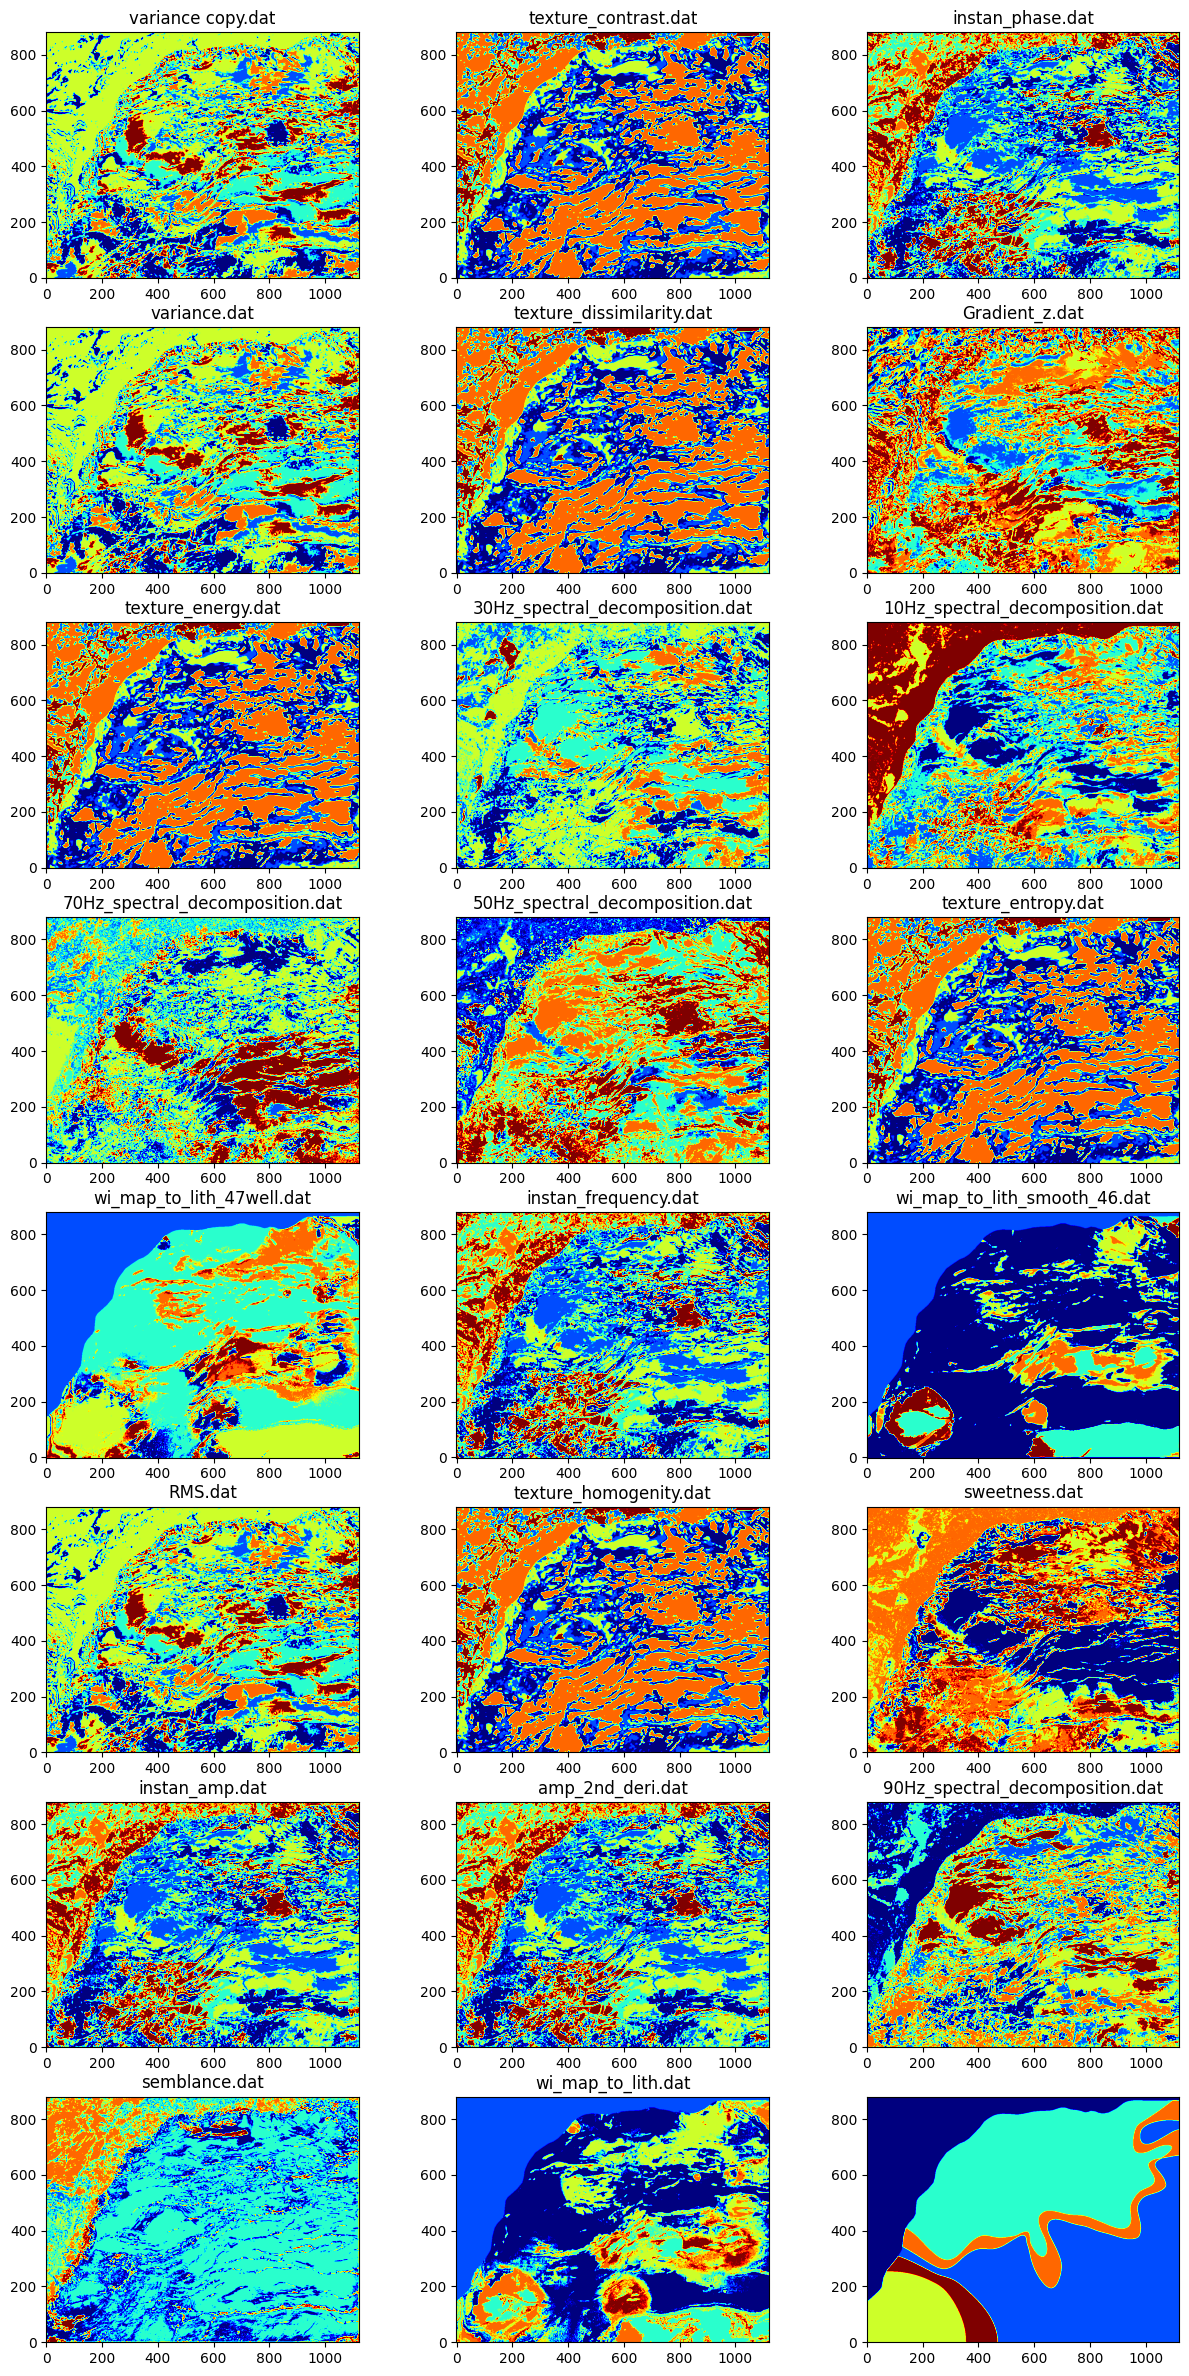

In [10]:
up = 0
down = 21
hors = np.zeros((n3,n2,up+down+1))
dir = os.listdir(rootpath + 'transfer/')
attrs = []
n = 1
plt.figure(figsize=(15,30))
for p in tqdm(dir):
    if 'dat' in p:
        attr = np.fromfile(rootpath + 'transfer/'+p,dtype=np.float32).reshape(n3,n2,n1)
        for i in range(n3):
            for j in range(n2):
                d = int(hor2[i,j])+5
                if d-up>0:
                    hors[i,j] = attr[i,j,d-up:d+down+1]
        features = hors.reshape(-1,up+down+1)
        kmeans = MiniBatchKMeans(init='k-means++', n_clusters=6, random_state=42,batch_size=100000,
                        verbose=0).fit(features)
        mat = kmeans.labels_.reshape(n3,n2)
        plt.subplot(8,3,n)
        plt.imshow(mat.T,origin='lower',cmap='jet')
        plt.title(p)
        n = n+1
for i in range(n3):
    for j in range(n2):
        d = int(hor2[i,j])
        if d-up>0:
            hors[i,j] = sx[i,j,d-up:d+down+1]

features = hors.reshape(-1,up+down+1)
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=6, random_state=42,batch_size=100000,
                verbose=0).fit(features)
mat = kmeans.labels_.reshape(n3,n2)
plt.subplot(8,3,n)
plt.imshow(mat.T,origin='lower',cmap='jet')

In [126]:
# hor2 = np.fromfile(rootpath+'New_T6xb1.dat',dtype=np.float32).reshape(n3,n2)*1000
# m = np.zeros_like(hor3)
# m[hor3>0] = 1
# hor2 = hor2 * m
# hor2.astype(np.float32).tofile('New_T6xb1.dat')

In [83]:

def get_label(name,hor):
    labelu = lithHor[name]
    wpu = []
    for inline in range(n3):
        for xline in range(n2):
            if labelu[inline][xline] > 0:
                # print(inline,xline,top[inline,xline],labelu[inline][xline])
                wpu.append([inline,xline,hor[inline,xline],labelu[inline][xline]])
                # print()
    wpu = np.array(wpu)
    return wpu

In [84]:
label_dict1 = {21:0,
              24:1,
              26:2}
label_dict2 = {21:0,
              24:1,
              26:2,}
label_dict3 = {21:0,
              24:1,
              25:2,
              26:3}


In [85]:
def get_label_data(wpu,label_dict):
    datu = []
    dlabelu = []
    dposu = []
    window = 15
    for i,info in enumerate(wpu):
        inline = int(info[0])
        xline = int(info[1])
        dep = round(info[2])
        l = label_dict[info[3]]
        if dep>0:
            d = sx[inline][xline][dep-window:dep+window+1].tolist()
            datu.append(d)
            dlabelu.append(l)
            dposu.append([inline,xline,dep])
    datu = np.array(datu)
    dlabelu = np.array(dlabelu)
    dposu = np.array(dposu)
    return datu,dlabelu,dposu

In [86]:
def get_pic_data(wpu,label_dict,hor):
    picd = []
    pichd = []
    dlabeld = []
    dposd = []
    ep = 25
    window = 25
    for i,info in enumerate(wpu):
        inline = int(info[0])
        xline = int(info[1])
        dep = round(info[2])
        l = label_dict[info[3]]
        if dep>0:
            pic1 = sx[inline-ep:inline+ep+1,xline,dep-window:dep+window+1].tolist()
            pic2 = sx[inline,xline-ep:xline+ep+1,dep-window:dep+window+1].tolist()
            pich1 = hor[inline-ep:inline+ep+1,xline]-(dep-window)
            pich1[pich1<0] = 0
            pich1[pich1>50] = 50
            pich2 = hor[inline,xline-ep:xline+ep+1]-(dep-window)
            pich2[pich2<0] = 0
            pich2[pich2>50] = 50
            picd.append([pic1,pic2])
            pichd.append([pich1,pich2])
            dlabeld.append(l)
            dposd.append([inline,xline,dep])
    picd = np.array(picd)
    pichd = np.array(pichd)
    dlabeld = np.array(dlabeld)
    dposd = np.array(dposd)
    return picd,pichd,dlabeld,dposd

In [107]:
def plot_slice(dlabelu,label_dictu,picu,pichu,window=25,ep=25):
    unique_values, counts = np.unique(dlabelu, return_counts=True)
    _, ax = plt.subplots(max(counts),len(unique_values)*2,figsize=(20,20))
    for i in range(len(list(label_dictu))):  
        for j,pd in enumerate(picu[dlabelu==i]):
            ax[j][2*i].imshow(pd[0].T,cmap='seismic')
            ax[j][2*i].plot(pichu[dlabelu==i][j][0],'k',linewidth=2)
            ax[j][2*i].plot(np.ones(2*window+1)*ep,np.arange(2*ep+1),'w',linewidth=2)
            ax[j][2*i+1].imshow(pd[1].T,cmap='seismic')
            ax[j][2*i+1].plot(pichu[dlabelu==i][j][1],'k',linewidth=2)
            ax[j][2*i+1].plot(np.ones(2*window+1)*ep,np.arange(2*ep+1),'w',linewidth=2)
def plot_wave(label_dictu,datu,dlabelu):
    plt.figure(figsize=(7,5))
    for i in range(len(list(label_dictu))):  
        plt.subplot(1,len(list(label_dictu)),i+1)  
        for j,pd in enumerate(datu[dlabelu==i]):
            plt.plot(pd+j*20000)
        plt.ylim([-10000,len(datu)*18000])
        plt.title(str(list(label_dictu.keys())[i]))

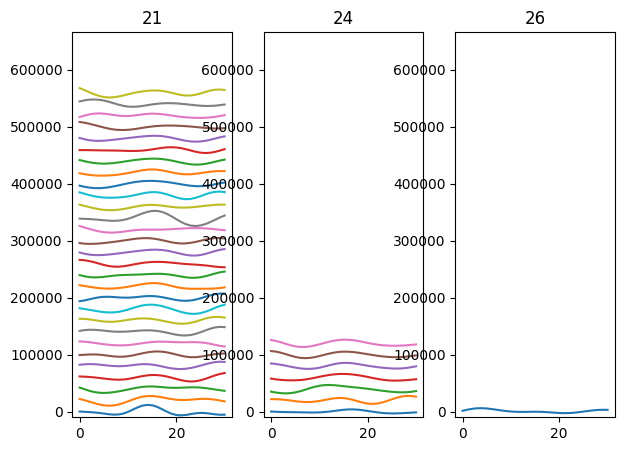

In [108]:
wp1 = get_label('es4cs2',hor1)
dat1,dlabel1,dpos1 = get_label_data(wp1,label_dict1)
pic1,pich1,dlabel1,dpos1 = get_pic_data(wp1,label_dict1,hor1)
# plot_slice(dlabel1,label_dict1,pic1,pich1,window=25,ep=25)
plot_wave(label_dict1,dat1,dlabel1)

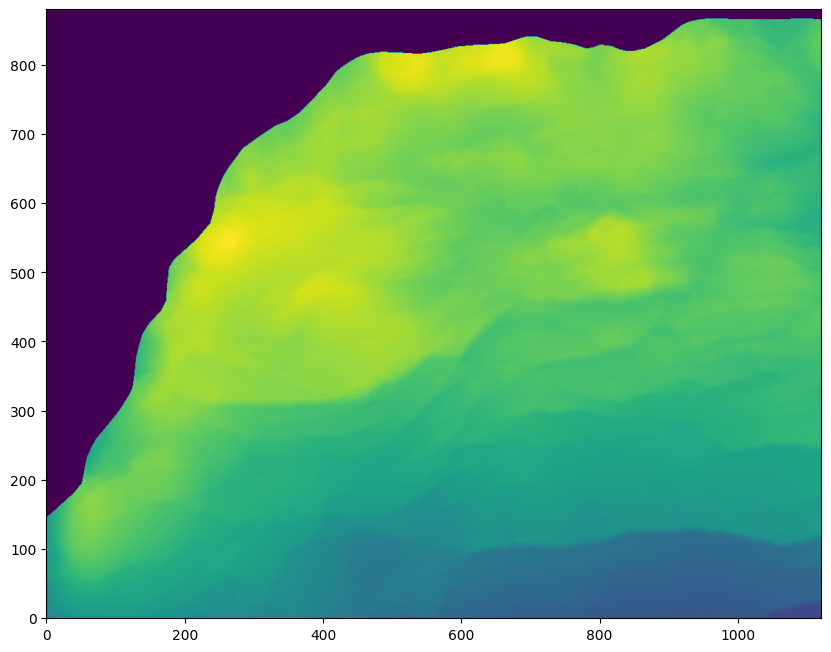

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(hor3.T,origin='lower')

array([[-13.850525, -14.627014, -14.839478, ...,   0.      ,   0.      ,
          0.      ],
       [-13.988037, -14.764038, -14.784973, ...,   0.      ,   0.      ,
          0.      ],
       [-14.444519, -15.208984, -14.915955, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [-25.149963, -23.940002, -22.188477, ...,   0.      ,   0.      ,
          0.      ],
       [-27.806458, -25.817993, -23.258057, ...,   0.      ,   0.      ,
          0.      ],
       [-28.399963, -26.250977, -23.514526, ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

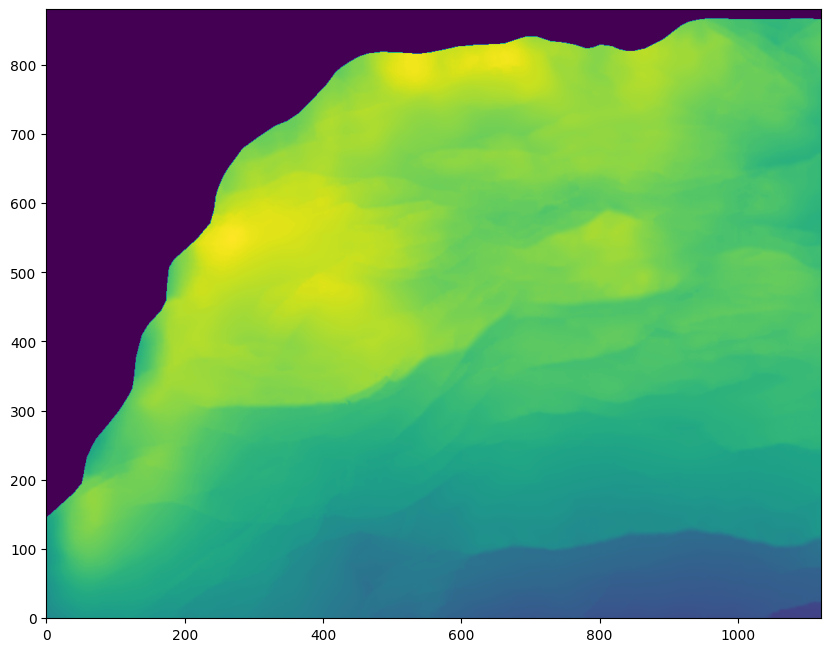

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(hor2.T,origin='lower')
hor2-hor3
# plt.scatter(wp1[:,0],wp1[:,1],c=wp1[:,3])
# plt.scatter(wpd[:,0],wpd[:,1],c='b',s=2)

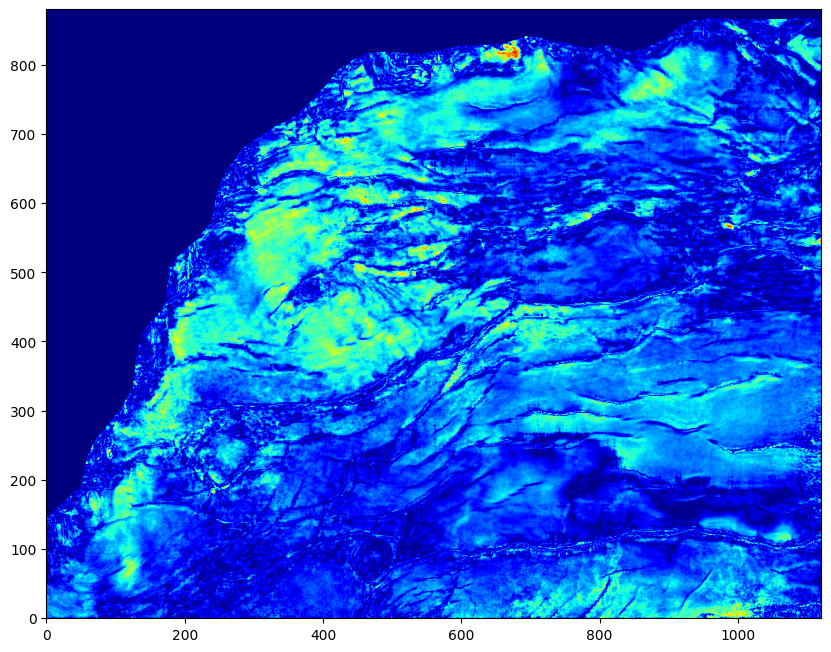

In [24]:
window= 1
samples_t = np.zeros((sx.shape[0],sx.shape[1],2*window+1))
for i3 in range(0,n3):
    for i2 in range(0,n2):
        h = round(hor2[i3,i2])
        if h>1:
            samples_t[i3,i2] = sx[i3,i2,h-window:h+window+1]
plt.figure(figsize=(10,10))
plt.imshow(abs(samples_t[:,:,window]).T,cmap='jet',origin='lower')
# plt.scatter(wp1[:,0],wp1[:,1],c=wp1[:,3])

In [137]:
samples_t.max()

179.99993896484375

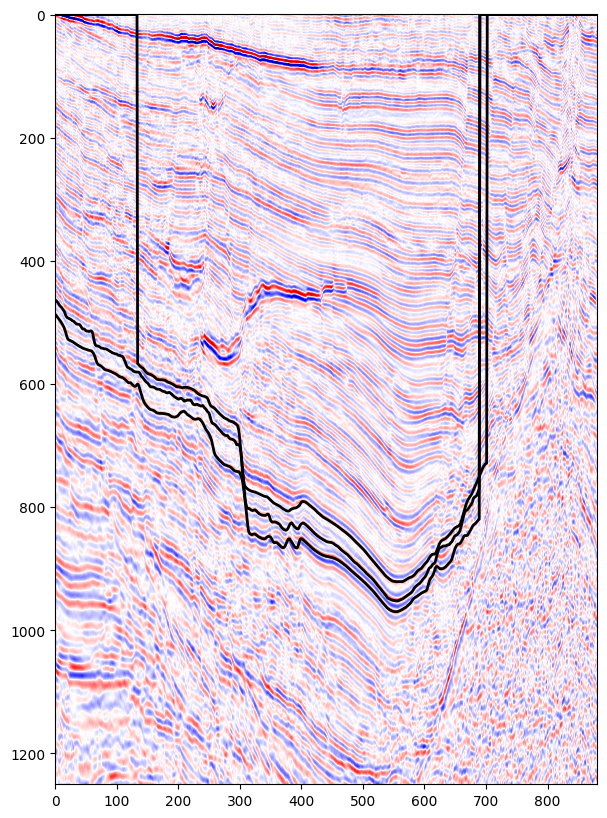

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(sx[300,:,:].T,cmap='seismic')
plt.plot(hor1[300,:],c='k',linewidth=2)
plt.plot(hor2[300,:],c='k',linewidth=2)
plt.plot(hor3[300,:],c='k',linewidth=2)